# Реализация градиентного спуска

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [ ]:
data = pd.read_csv('data.csv')
data.head(3)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [ ]:
from sklearn.linear_model import LinearRegression

X = data.drop(['target'], axis=1)
Y = data['target']

model = LinearRegression()
model.fit(X, Y)

model.coef_, model.intercept_

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 np.float64(4.37315703870712))

Теперь реализуем класс для оптимизации коэффициентов линейной регрессии МНК.
На вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.


**Hint: пример вычисления производной**

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек:
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [ ]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6,
                 copy: bool = True):
      if copy == True:
        self.samples = samples.copy()
      if copy == False:
        self.samples = samples
      self.targets = targets
      self.learning_rate = learning_rate
      self.threshold = threshold
      self.copy = copy
      self.betas = np.ones(self.samples.shape[1])
      self.iteration_loss_dict = {}

    def add_constant_feature(self):
      """
        Метод для создания константной фичи в матрице объектов samples
      """
      self.samples['constant'] = 1
      self.betas = np.append(self.betas, 1)

    def calculate_mse_loss(self) -> float:
      """
        Метод для расчета среднеквадратической ошибки
      """
      return np.mean((np.dot(self.samples, self.betas) - self.targets) ** 2)

    def calculate_gradient(self) -> np.ndarray:
      """
        Метод для вычисления вектора-градиента
      """
      loss = np.dot(self.samples, self.betas) - self.targets
      return (np.dot(loss, self.samples)) * 2 / self.samples.shape[0]

    def iteration(self):
      """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
      """
      self.betas = self.betas - self.learning_rate * self.calculate_gradient()

    def learn(self):
      """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict
      """
      old_mse = self.calculate_mse_loss()
      self.iteration()
      new_mse = self.calculate_mse_loss()

      self.iteration_loss_dict[0] = old_mse
      self.iteration_loss_dict[1] = new_mse

      self.iteration_step = 1

      while (abs(old_mse - new_mse) > self.threshold):
        old_mse = new_mse
        self.iteration()
        new_mse = self.calculate_mse_loss()

        self.iteration_step += 1

        self.iteration_loss_dict[self.iteration_step] = new_mse

Обучим коэффициенты линейной модели с помощью реализованного градиентного спуска

In [ ]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [ ]:
print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD.betas))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

[0.88733305 1.90100713 2.88063607 3.87662612 4.89623507 5.89126182
 6.89254811 7.90311947 8.87580109 9.86109585 4.94854733]


Построим **траектории обучения** для различных **learning rate**'ов и **threshold**'ов.

Исследуются следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

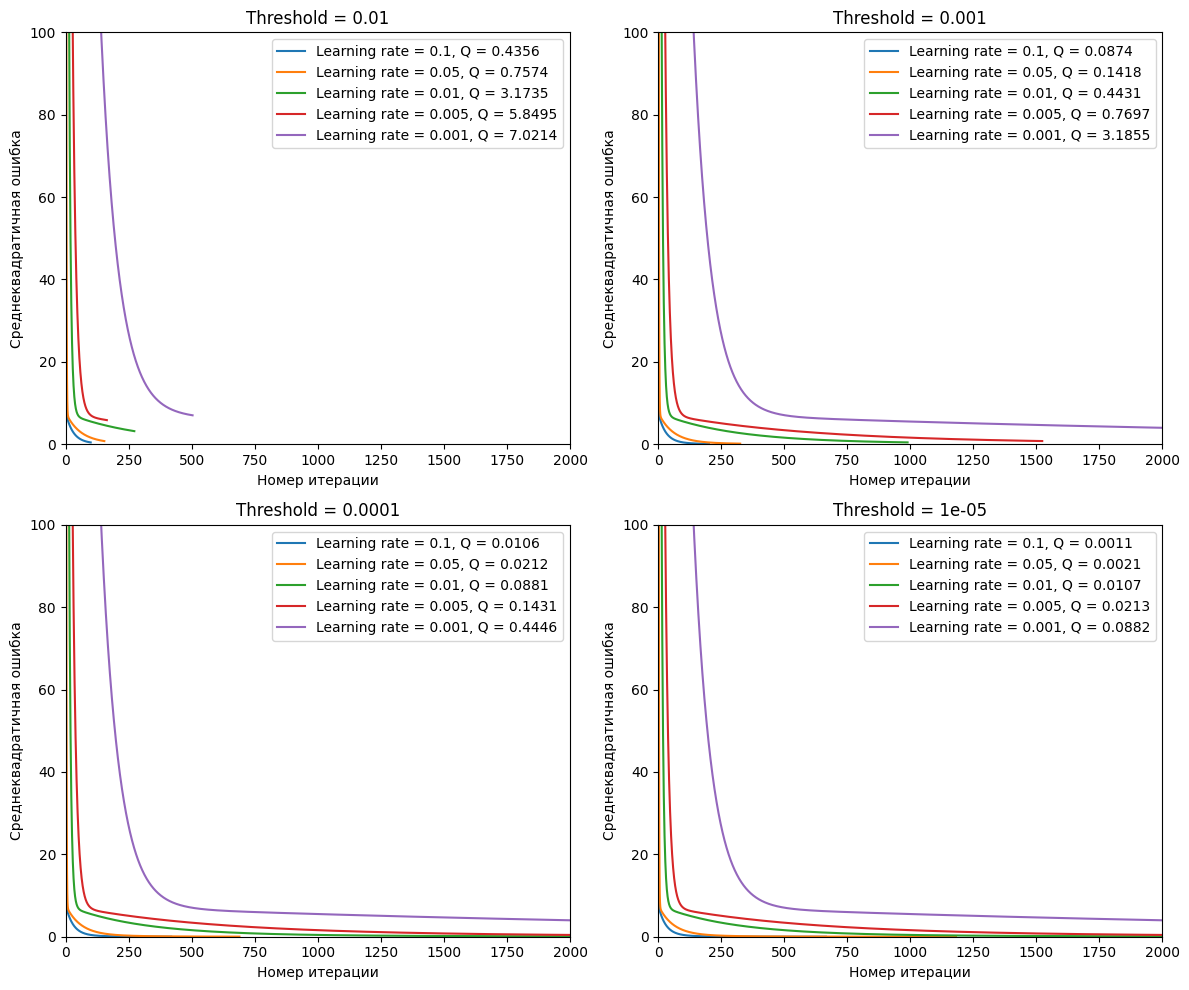

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 10)

thresholds = [1e-2, 1e-3, 1e-4, 1e-5]
learning_rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]

for i in range(len(thresholds)):
  th = thresholds[i]

  ax = fig.add_subplot(2, 2, i + 1)

  for_legend = []

  for lr in learning_rates:
    GD = GradientDescentMse(samples=X, targets=Y, threshold=th, learning_rate=lr)
    GD.add_constant_feature()
    GD.learn()

    plt.plot(GD.iteration_loss_dict.keys(), GD.iteration_loss_dict.values())

    plt.xlim(0, 2000)
    plt.ylim(0, 100)

    for_legend.append(f'Learning rate = {lr}, Q = {round(list(GD.iteration_loss_dict.values())[-1], 4)}')

  plt.xlabel('Номер итерации')
  plt.ylabel('Среднеквадратичная ошибка')
  plt.title(f'Threshold = {th}')
  plt.legend(for_legend)

fig.tight_layout()

plt.show()